<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<br>
<font size=6>
Homework 2
</font><br>
<font size=4>


# Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install gdown
!pip install torchmetrics
!pip install pytorch-metric-learning
!pip -q install wandb

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [2]:
import gdown
import pickle
import wandb
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchmetrics
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
import pickle
import warnings
warnings.filterwarnings('ignore')

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")



In [3]:
!wandb login --relogin
# Type your API

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
train_file_path = '/content/drive/MyDrive/Data/train.pickle'
validation_file_path = '/content/drive/MyDrive/Data/validation.pickle'
test_file_path = '/content/drive/MyDrive/Data/test.pickle'

# Load the pickle file into a list
with open(train_file_path, 'rb') as file:
    train_data = pickle.load(file)

with open(validation_file_path, 'rb') as file:
    validation_data = pickle.load(file)

with open(test_file_path, 'rb') as file:
    test_data = pickle.load(file)



In [5]:
train_data_len = len(train_data)
classes = ['Meningioma', 'Glioma', 'Pitutary']
n_classes = len(classes)

train_image = []
y_raw_train = []

for i in train_data:
    train_image.append(i[0])
    y_raw_train.append(i[1])

train_label = list(np.asarray(y_raw_train)-np.ones(train_data_len,dtype=np.int))

In [6]:
validation_data_len = len(validation_data)

validation_image = []
y_raw_validation = []

for i in validation_data:
    validation_image.append(i[0])
    y_raw_validation.append(i[1])

validation_label = list(np.asarray(y_raw_validation)-np.ones(validation_data_len,dtype=np.int))

In [7]:
test_data_len = len(test_data)

test_image = []
y_raw_test = []

for i in test_data:
    test_image.append(i[0])
    y_raw_test.append(i[1])

test_label = list(np.asarray(y_raw_test)-np.ones(test_data_len,dtype=np.int))

# Visualization

In [8]:
sample = []
sample_size = 4
for i in range(1, n_classes+1):
    temp = []
    key = 0
    while True:
        index = y_raw_train.index(i,key,train_data_len-1)
        key = index+1
        temp.append(train_image[index])

        if len(temp) == sample_size:
            break

    sample.append(temp)
sample = np.asarray(sample)
print(f'sample contains {len(sample)} classes with {len(sample[0])} samples in each class')

sample contains 3 classes with 4 samples in each class


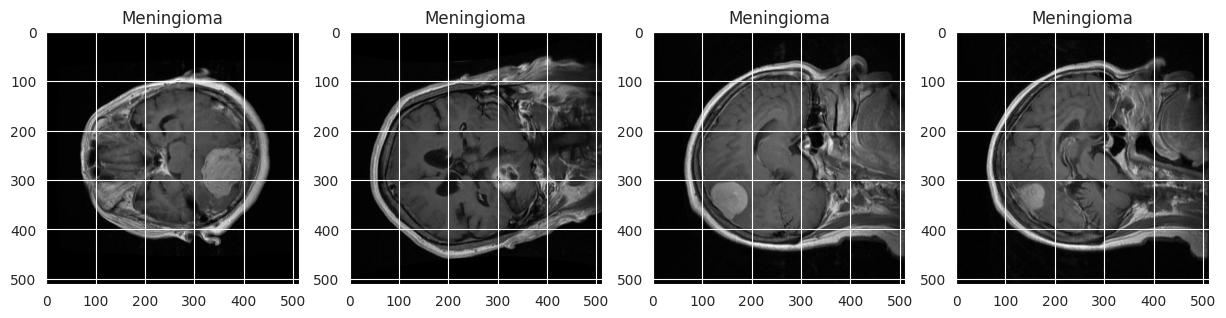

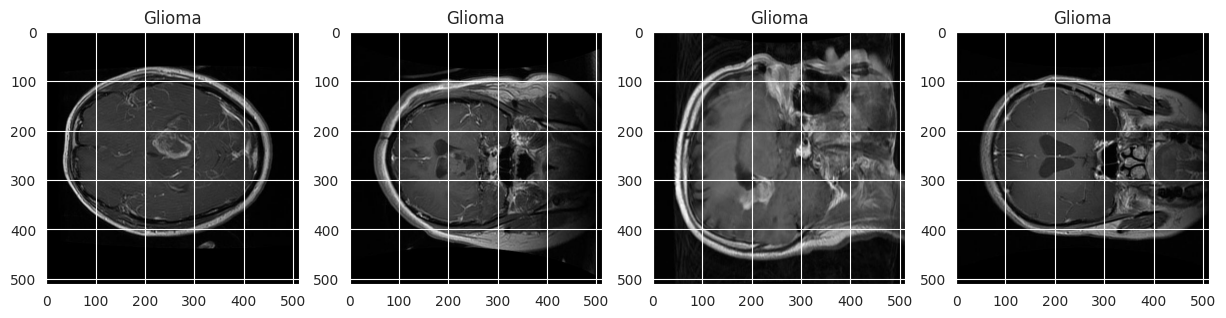

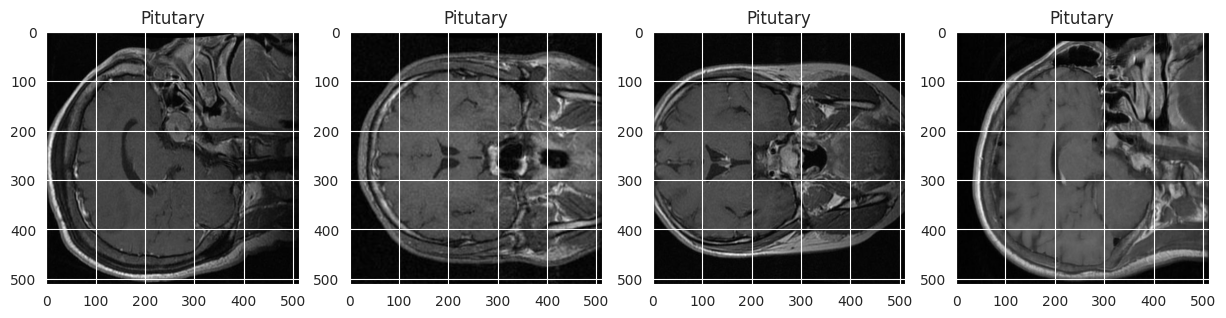

In [9]:
for i in range(n_classes):
    fig = plt.figure(figsize=(15,15))
    for j in range(sample_size):
        fig.add_subplot(i+1,sample_size ,j+1)
        plt.title(classes[i])
        plt.imshow(sample[i][j])


# Dataset & Dataloader

In [10]:
class Dataset(Dataset):
    def __init__(self,x,y,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.y = y
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self,i):
        return torch.FloatTensor(np.asarray(self.transform(Image.fromarray(self.x[i])))),torch.LongTensor([self.y[i]])

batch_size = 16

transforms_train = T.Compose([
        T.Resize((224,224)),
        T.RandomRotation(degrees=(-45, 45)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Dataset(train_image,train_label,transform =transforms_train)
validation_dataset = Dataset(validation_image,validation_label,transform =transforms_test)
test_dataset = Dataset(test_image,test_label,transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = True )

# Alexnet from scratch

In [11]:
wandb.init(project="HW2_ANS",
           name='AlexNet-fromscratch')

wandb: Currently logged in as: daniahangaranii. Use `wandb login --relogin` to force relogin


In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3, return_embs = False):
        super(AlexNet, self).__init__()
        self.return_embs = return_embs
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        #self.linear_reducer = nn.LazyLinear(128)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        #x = self.linear_reducer(x)
        if(not self.return_embs):
          x = self.classifier(x)
        return x



In [13]:
# Create an instance of the AlexNet model
model_from_scratch = AlexNet(num_classes=3)

In [ ]:
lr = 0.0015
epoch = 20

device = 'cuda'
model_from_scratch = model_from_scratch.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_from_scratch.parameters(),lr = lr)

training

In [16]:
f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=3).to(device)
acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)
best_val_model_state = None
best_val_loss = float("inf")

train_loss_hist = []
train_acc_hist = []
train_f1_hist = []

val_loss_hist = []
val_acc_hist = []
val_f1_hist = []

for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    train_acc_batch_sum = 0
    train_f1_batch_sum = 0
    for batch_idx , (train_x,train_y) in enumerate(train_dataloader):
      model_from_scratch.train() # Setting mode to train
      optimizer.zero_grad()
      train_x , train_y = train_x.to(device) , train_y.to(device)
      train_y_pred = model_from_scratch(train_x)

      # Calculating Loss
      train_loss = criterion(train_y_pred, torch.squeeze(train_y))
      train_loss.backward()
      optimizer.step()

      # Calculate Metrics
      train_batch_f1 = f1_metric(torch.argmax(train_y_pred, dim = 1), torch.squeeze(train_y))
      train_batch_acc = acc_metric(torch.argmax(train_y_pred, dim = 1), torch.squeeze(train_y))
      train_acc_batch_sum += train_batch_acc
      train_f1_batch_sum += train_batch_f1
    # End of Batch Loop

    train_acc = train_acc_batch_sum/train_dataloader.__len__()
    train_f1 = train_f1_batch_sum/train_dataloader.__len__()

    # Calculating loss and accuracy for validation
    val_acc_batch_sum = 0
    val_f1_batch_sum = 0
    with torch.no_grad():
        model_from_scratch.eval()
        for _batch_idx_ , (val_x ,val_y) in enumerate(validation_dataloader):
            val_x , val_y = val_x.to(device) , val_y.to(device)
            val_y_pred = model_from_scratch(val_x)
            val_loss = criterion(val_y_pred, torch.squeeze(val_y))

            val_batch_f1 = f1_metric(torch.argmax(val_y_pred, dim = 1), torch.squeeze(val_y))
            val_batch_acc = acc_metric(torch.argmax(val_y_pred, dim = 1), torch.squeeze(val_y))

            val_acc_batch_sum += val_batch_acc
            val_f1_batch_sum += val_batch_f1
        val_acc = val_acc_batch_sum/validation_dataloader.__len__()
        val_f1 = val_f1_batch_sum/validation_dataloader.__len__()

    best_updated = False
    if(val_loss < best_val_loss):
      best_val_loss = val_loss
      best_val_model_state = model_from_scratch.state_dict()
      best_updated = True

    log = "Train Loss: %.4f, Train Acc: %.4f, Train F1: %.4f, Val Loss: %.4f, Val Acc: %.4f, Val F1: %.4f, Best: %s" % \
    (train_loss, train_acc, train_f1, val_loss, val_acc, val_f1, best_updated)
    wandb.log({"train_loss": train_loss, "train_accuracy": train_acc, "train_f1_score": train_f1,
               "val_loss": val_loss, "val_accuracy": val_acc, "val_f1_score": val_f1, "epoch": epoch})
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    train_f1_hist.append(train_f1_batch_sum)

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    val_f1_hist.append(val_f1_batch_sum)


    print(log, "\n")



---------------------------------------EPOCH 1-------------------------------------------
Train Loss: 1.0167, Train Acc: 0.4633, Train F1: 0.4633, Val Loss: 0.8538, Val Acc: 0.4875, Val F1: 0.4875, Best: True 

---------------------------------------EPOCH 2-------------------------------------------
Train Loss: 1.0170, Train Acc: 0.4633, Train F1: 0.4633, Val Loss: 1.2615, Val Acc: 0.4437, Val F1: 0.4437, Best: False 

---------------------------------------EPOCH 3-------------------------------------------
Train Loss: 1.1235, Train Acc: 0.4616, Train F1: 0.4616, Val Loss: 1.0020, Val Acc: 0.4656, Val F1: 0.4656, Best: False 

---------------------------------------EPOCH 4-------------------------------------------
Train Loss: 0.9404, Train Acc: 0.4633, Train F1: 0.4633, Val Loss: 0.9966, Val Acc: 0.4656, Val F1: 0.4656, Best: False 

---------------------------------------EPOCH 5-------------------------------------------
Train Loss: 0.9346, Train Acc: 0.4633, Train F1: 0.4633, Val Lo

testing

In [17]:
# Calculating loss and accuracy for test
best_val_model = AlexNet(num_classes=3)
best_val_model.load_state_dict(best_val_model_state)
best_val_model = best_val_model.to(device)
test_acc_batch_sum = 0
test_f1_batch_sum = 0
with torch.no_grad():
    model_from_scratch.eval()
    for _batch_idx_ , (test_x ,test_y) in enumerate(test_dataloader):
        test_x , test_y = test_x.to(device) , test_y.to(device)
        test_y_pred = model_from_scratch(test_x)
        test_loss = criterion(test_y_pred, torch.squeeze(test_y))

        test_batch_f1 = f1_metric(torch.argmax(test_y_pred, dim = 1), torch.squeeze(test_y))
        test_batch_acc = acc_metric(torch.argmax(test_y_pred, dim = 1), torch.squeeze(test_y))

        test_acc_batch_sum += test_batch_acc
        test_f1_batch_sum += test_batch_f1
    test_acc = test_acc_batch_sum/test_dataloader.__len__()
    test_f1 = test_f1_batch_sum/test_dataloader.__len__()

log = ("Test Loss: %.4f, Test Acc: %.4f, Test F1: %.4f") % (test_loss, test_acc, test_f1)
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc, "test_f1_score": test_f1})
print(log)

Test Loss: 1.0004, Test Acc: 0.4990, Test F1: 0.4990


# Alexnet pretrain

In [18]:
wandb.init(project="HW2_ANS",
           name='AlexNet-pretrain')

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1_score,▁
test_loss,▁
train_accuracy,▁█▆▆▆█▄███▆██▄▆▆▄▆▆██▆▆▄█▆▄▆
train_f1_score,▁█▆▆▆█▄███▆██▄▆▆▄▆▆██▆▆▄█▆▄▆
train_loss,▅▄▅▄▅▃▆▂▃▃▅▂▂█▄▅▆▅▅▃▁▇▅█▁▅█▅
val_accuracy,▅▅███▅▅██▁▅▅▁▅▁█▁▅▁██▁█▁▅█▅▁
val_f1_score,▅▅███▅▅██▁▅▅▁▅▁█▁▅▁██▁█▁▅█▅▁
val_loss,▅▅▄▃▃▅▄▂▂▇▄▄█▄█▁▆▅█▁▁█▁█▅▁▄▆
epoch,20


In [ ]:
model_pretrained = models.alexnet(pretrained=True)
num_features = model_pretrained.classifier[6].in_features
model_pretrained.classifier[6] = nn.Linear(num_features, 3)
model_pretrained = model_pretrained.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_pretrained.parameters(),lr = lr)

training

In [20]:
f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=3, average = "weighted").to(device)
acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=3, average = "weighted").to(device)
best_pre_val_model_state = None
best_pre_val_loss = float("inf")

train_pre_loss_hist = []
train_pre_acc_hist = []
train_pre_f1_hist = []

val_pre_loss_hist = []
val_pre_acc_hist = []
val_pre_f1_hist = []
epoch = 20
for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    train_acc_batch_sum = 0
    train_f1_batch_sum = 0
    for batch_idx , (train_x,train_y) in enumerate(train_dataloader):
      model_pretrained.train() # Setting mode to train
      optimizer.zero_grad()
      train_x , train_y = train_x.to(device) , train_y.to(device)
      train_y_pred = model_pretrained(train_x)

      # Calculating Loss
      train_loss = criterion(train_y_pred, torch.squeeze(train_y))
      train_loss.backward()
      optimizer.step()

      # Calculate Metrics
      train_batch_f1 = f1_metric(torch.argmax(train_y_pred, dim = 1), torch.squeeze(train_y))
      train_batch_acc = acc_metric(torch.argmax(train_y_pred, dim = 1), torch.squeeze(train_y))
      train_acc_batch_sum += train_batch_acc
      train_f1_batch_sum += train_batch_f1
    # End of Batch Loop

    train_acc = train_acc_batch_sum/train_dataloader.__len__()
    train_f1 = train_f1_batch_sum/train_dataloader.__len__()

    # Calculating loss and accuracy for validation
    val_acc_batch_sum = 0
    val_f1_batch_sum = 0
    with torch.no_grad():

        model_pretrained.eval()
        for _batch_idx_ , (val_x ,val_y) in enumerate(validation_dataloader):
            val_x , val_y = val_x.to(device) , val_y.to(device)
            val_y_pred = model_pretrained(val_x)
            val_loss = criterion(val_y_pred, torch.squeeze(val_y))

            val_batch_f1 = f1_metric(torch.argmax(val_y_pred, dim = 1), torch.squeeze(val_y))
            val_batch_acc = acc_metric(torch.argmax(val_y_pred, dim = 1), torch.squeeze(val_y))

            val_acc_batch_sum += val_batch_acc
            val_f1_batch_sum += val_batch_f1
        val_acc = val_acc_batch_sum/validation_dataloader.__len__()
        val_f1 = val_f1_batch_sum/validation_dataloader.__len__()

    best_updated = False
    if(val_loss < best_pre_val_loss):
      best_pre_val_loss = val_loss
      best_pre_val_model_state = model_pretrained.state_dict()
      best_updated = True

    log = "Train Loss: %.4f, Train Acc: %.4f, Train F1: %.4f, Val Loss: %.4f, Val Acc: %.4f, Val F1: %.4f, Best: %s" % \
    (train_loss, train_acc, train_f1, val_loss, val_acc, val_f1, best_updated)
    wandb.log({"train_loss": train_loss, "train_accuracy": train_acc, "train_f1_score": train_f1,
               "val_loss": val_loss, "val_accuracy": val_acc, "val_f1_score": val_f1, "epoch": epoch})
    train_pre_loss_hist.append(train_loss)
    train_pre_acc_hist.append(train_acc)
    train_pre_f1_hist.append(train_f1_batch_sum)

    val_pre_loss_hist.append(val_loss)
    val_pre_acc_hist.append(val_acc)
    val_pre_f1_hist.append(val_f1_batch_sum)


    print(log, "\n")

---------------------------------------EPOCH 1-------------------------------------------
Train Loss: 0.0545, Train Acc: 0.7411, Train F1: 0.7221, Val Loss: 1.6882, Val Acc: 0.6938, Val F1: 0.6943, Best: True 

---------------------------------------EPOCH 2-------------------------------------------
Train Loss: 1.4776, Train Acc: 0.8325, Train F1: 0.8302, Val Loss: 1.2713, Val Acc: 0.4000, Val F1: 0.3121, Best: True 

---------------------------------------EPOCH 3-------------------------------------------
Train Loss: 0.1933, Train Acc: 0.8478, Train F1: 0.8424, Val Loss: 0.0778, Val Acc: 0.8344, Val F1: 0.8153, Best: True 

---------------------------------------EPOCH 4-------------------------------------------
Train Loss: 0.2432, Train Acc: 0.8742, Train F1: 0.8712, Val Loss: 1.2141, Val Acc: 0.8000, Val F1: 0.7884, Best: False 

---------------------------------------EPOCH 5-------------------------------------------
Train Loss: 0.0365, Train Acc: 0.8722, Train F1: 0.8699, Val Loss

testing

In [21]:
# Calculating loss and accuracy for test
best_pre_model = models.alexnet(pretrained=True)
num_features = best_pre_model.classifier[6].in_features
best_pre_model.classifier[6] = nn.Linear(num_features, 3)
best_pre_model = best_pre_model.to(device)
best_pre_model.load_state_dict(best_pre_val_model_state)

test_acc_batch_sum = 0
test_f1_batch_sum = 0
with torch.no_grad():
    model_from_scratch.eval()
    for _batch_idx_ , (test_x ,test_y) in enumerate(test_dataloader):
        test_x , test_y = test_x.to(device) , test_y.to(device)
        test_y_pred = best_pre_model(test_x)
        test_loss = criterion(test_y_pred, torch.squeeze(test_y))

        test_batch_f1 = f1_metric(torch.argmax(test_y_pred, dim = 1), torch.squeeze(test_y))
        test_batch_acc = acc_metric(torch.argmax(test_y_pred, dim = 1), torch.squeeze(test_y))

        test_acc_batch_sum += test_batch_acc
        test_f1_batch_sum += test_batch_f1
    test_acc = test_acc_batch_sum/test_dataloader.__len__()
    test_f1 = test_f1_batch_sum/test_dataloader.__len__()

log = ("Test Loss: %.4f, Test Acc: %.4f, Test F1: %.4f") % (test_loss, test_acc, test_f1)
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc, "test_f1_score": test_f1})
print(log)

Test Loss: 0.0005, Test Acc: 0.9062, Test F1: 0.9078


# Contrastive + Cross Entropy

In [22]:
wandb.init(project="HW2_ANS",
           name='AlexNet-SUPC')

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1_score,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇█▇█▇█████
train_f1_score,▁▅▅▆▆▇▇▇▇▇▇███▇█████
train_loss,▁█▂▂▁▅▂▁▁▅▁▅▁▁▁▁▁▂▂▁
val_accuracy,▅▁▇▆▇▅▇█▇▇█▇██████▇█
val_f1_score,▅▁▇▇▇▆██▇▇█▇████████
val_loss,█▆▁▆▆▁▄▂▄▆▁▁▁▂▃▁▁▁▆▁
epoch,20


Supervised Contrastive Loss

In [24]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        
        features_normalized = F.normalize(features, p=2, dim=1)
        # Compute the similarity matrix
        similarity_matrix = torch.mm(features_normalized, features_normalized.t()) / self.temperature

        # Use the labels to create a mask
        mask = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1)).float()

        # Calculate the log-sum-exp for the denominator of the loss
        exp_sim = torch.exp(similarity_matrix - torch.eye(len(features)).to(features.device) * 1e12)

        # Calculates sum of differences with all samples
        denominator = torch.log(torch.sum(exp_sim, dim=1))

        # Calculate the positive pair loss
        positive_pairs = torch.sum(similarity_matrix * mask, dim=1) / torch.sum(mask, dim=1)

        # Calculate the total loss
        loss = -torch.mean(torch.log(positive_pairs / (denominator)))

        return loss


In [ ]:
lr = 0.01
epoch = 10

device = 'cuda'
model_from_scratch = AlexNet(return_embs = True)
model_from_scratch = model_from_scratch.to(device)


criterion = SupConLoss(temperature = 0.5)
optimizer = torch.optim.SGD(model_from_scratch.parameters(),lr = lr)

Contrastive

In [26]:
best_val_model_state = None
best_val_loss = float("inf")

train_loss_hist = []
val_loss_hist = []

for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    for batch_idx , (train_x, train_y) in enumerate(train_dataloader):
      model_from_scratch.train() # Setting mode to train
      optimizer.zero_grad()
      train_x , train_y = train_x.to(device) , train_y.to(device)
      train_y_emb = model_from_scratch(train_x)

      # Calculating Loss
      # train_y_emb = torch.unsqueeze(train_y_emb, dim = 1)
      train_loss = criterion(train_y_emb, torch.squeeze(train_y))
      train_loss.backward()
      optimizer.step()

    # End of Batch Loop

    # Calculating loss for validation
    val_f1_batch_sum = 0
    with torch.no_grad():
        model_from_scratch.eval()
        for _batch_idx_ , (val_x ,val_y) in enumerate(validation_dataloader):
            val_x , val_y = val_x.to(device) , val_y.to(device)
            val_y_emb = model_from_scratch(val_x)
            val_loss = criterion(val_y_emb, torch.squeeze(val_y))

    best_updated = False
    if(val_loss < best_val_loss):
      best_val_loss = val_loss
      best_val_model_state = model_from_scratch.state_dict()
      best_updated = True

    log = "Train Loss: %.4f, Val Loss: %.4f, %s" % (train_loss, val_loss, best_updated)
    wandb.log({"Train_loss": train_loss, "val_loss": val_loss})
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)

    print(log, "\n")



---------------------------------------EPOCH 1-------------------------------------------
Train Loss: 0.2973, Val Loss: -0.0025, True 

---------------------------------------EPOCH 2-------------------------------------------
Train Loss: 0.2974, Val Loss: -0.0008, False 

---------------------------------------EPOCH 3-------------------------------------------
Train Loss: 0.2964, Val Loss: -0.0035, True 

---------------------------------------EPOCH 4-------------------------------------------
Train Loss: 0.2969, Val Loss: -0.0006, False 

---------------------------------------EPOCH 5-------------------------------------------
Train Loss: 0.2969, Val Loss: -0.0017, False 

---------------------------------------EPOCH 6-------------------------------------------
Train Loss: 0.2966, Val Loss: -0.0010, False 

---------------------------------------EPOCH 7-------------------------------------------
Train Loss: 0.2967, Val Loss: -0.0013, False 

---------------------------------------EPOC

In [ ]:
model_from_scratch.return_embs = False
lr = 0.015
epoch = 15

device = 'cuda'
model_from_scratch = model_from_scratch.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_from_scratch.parameters(),lr = lr)

Cross Entropy

In [28]:
f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=3).to(device)
acc_metric = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)
best_val_model_state = None
best_val_loss = float("inf")

train_loss_hist = []
train_acc_hist = []
train_f1_hist = []

val_loss_hist = []
val_acc_hist = []
val_f1_hist = []

for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    train_acc_batch_sum = 0
    train_f1_batch_sum = 0
    for batch_idx , (train_x,train_y) in enumerate(train_dataloader):
      model_from_scratch.train() # Setting mode to train
      optimizer.zero_grad()
      train_x , train_y = train_x.to(device) , train_y.to(device)
      train_y_pred = model_from_scratch(train_x)

      # Calculating Loss
      train_loss = criterion(train_y_pred, torch.squeeze(train_y))
      train_loss.backward()
      optimizer.step()

      # Calculate Metrics
      train_batch_f1 = f1_metric(torch.argmax(train_y_pred, dim = 1), torch.squeeze(train_y))
      train_batch_acc = acc_metric(torch.argmax(train_y_pred, dim = 1), torch.squeeze(train_y))
      train_acc_batch_sum += train_batch_acc
      train_f1_batch_sum += train_batch_f1
    # End of Batch Loop

    train_acc = train_acc_batch_sum/train_dataloader.__len__()
    train_f1 = train_f1_batch_sum/train_dataloader.__len__()

    # Calculating loss and accuracy for validation
    val_acc_batch_sum = 0
    val_f1_batch_sum = 0
    with torch.no_grad():
        model_from_scratch.eval()
        for _batch_idx_ , (val_x ,val_y) in enumerate(validation_dataloader):
            val_x , val_y = val_x.to(device) , val_y.to(device)
            val_y_pred = model_from_scratch(val_x)
            val_loss = criterion(val_y_pred, torch.squeeze(val_y))

            val_batch_f1 = f1_metric(torch.argmax(val_y_pred, dim = 1), torch.squeeze(val_y))
            val_batch_acc = acc_metric(torch.argmax(val_y_pred, dim = 1), torch.squeeze(val_y))

            val_acc_batch_sum += val_batch_acc
            val_f1_batch_sum += val_batch_f1
        val_acc = val_acc_batch_sum/validation_dataloader.__len__()
        val_f1 = val_f1_batch_sum/validation_dataloader.__len__()

    best_updated = False
    if(val_loss < best_val_loss):
      best_val_loss = val_loss
      best_val_model_state = model_from_scratch.state_dict()
      best_updated = True

    log = "Train Loss: %.4f, Train Acc: %.4f, Train F1: %.4f, Val Loss: %.4f, Val Acc: %.4f, Val F1: %.4f, Best: %s" % \
    (train_loss, train_acc, train_f1, val_loss, val_acc, val_f1, best_updated)
    wandb.log({"train_loss": train_loss, "train_accuracy": train_acc, "train_f1_score": train_f1,
               "val_loss": val_loss, "val_accuracy": val_acc, "val_f1_score": val_f1, "epoch": epoch})
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    train_f1_hist.append(train_f1_batch_sum)

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    val_f1_hist.append(val_f1_batch_sum)


    print(log, "\n")



---------------------------------------EPOCH 1-------------------------------------------
Train Loss: 1.0529, Train Acc: 0.4624, Train F1: 0.4624, Val Loss: 0.9856, Val Acc: 0.4656, Val F1: 0.4656, Best: True 

---------------------------------------EPOCH 2-------------------------------------------
Train Loss: 0.9304, Train Acc: 0.4633, Train F1: 0.4633, Val Loss: 1.1093, Val Acc: 0.4656, Val F1: 0.4656, Best: False 

---------------------------------------EPOCH 3-------------------------------------------
Train Loss: 1.0369, Train Acc: 0.4616, Train F1: 0.4616, Val Loss: 0.9550, Val Acc: 0.4656, Val F1: 0.4656, Best: True 

---------------------------------------EPOCH 4-------------------------------------------
Train Loss: 0.7620, Train Acc: 0.4651, Train F1: 0.4651, Val Loss: 0.9472, Val Acc: 0.4656, Val F1: 0.4656, Best: True 

---------------------------------------EPOCH 5-------------------------------------------
Train Loss: 1.2162, Train Acc: 0.4616, Train F1: 0.4616, Val Loss

testing

In [29]:
# Calculating loss and accuracy for test
best_val_model = AlexNet(num_classes=3)
best_val_model.load_state_dict(best_val_model_state)
best_val_model = best_val_model.to(device)
test_acc_batch_sum = 0
test_f1_batch_sum = 0
with torch.no_grad():
    model_from_scratch.eval()
    for _batch_idx_ , (test_x ,test_y) in enumerate(test_dataloader):
        test_x , test_y = test_x.to(device) , test_y.to(device)
        test_y_pred = model_from_scratch(test_x)
        test_loss = criterion(test_y_pred, torch.squeeze(test_y))

        test_batch_f1 = f1_metric(torch.argmax(test_y_pred, dim = 1), torch.squeeze(test_y))
        test_batch_acc = acc_metric(torch.argmax(test_y_pred, dim = 1), torch.squeeze(test_y))

        test_acc_batch_sum += test_batch_acc
        test_f1_batch_sum += test_batch_f1
    test_acc = test_acc_batch_sum/test_dataloader.__len__()
    test_f1 = test_f1_batch_sum/test_dataloader.__len__()

log = ("Test Loss: %.4f, Test Acc: %.4f, Test F1: %.4f") % (test_loss, test_acc, test_f1)
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc, "test_f1_score": test_f1})
print(log)

Test Loss: 1.2812, Test Acc: 0.6573, Test F1: 0.6573


In [30]:
wandb.finish()

Train_loss,▇█▁▅▄▂▃▃▂▄
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1_score,▁
test_loss,▁
train_accuracy,▁▁▁▁▁▁▃▄▅▅▆▇▇▇█
train_f1_score,▁▁▁▁▁▁▃▄▅▅▆▇▇▇█
train_loss,▅▅▅▄▆▃▂▃█▄▁▂▅▆▃
val_accuracy,▄▄▄▄▄▄▃▅▁█▇▇▇█▇
val_f1_score,▄▄▄▄▄▄▃▅▁█▇▇▇█▇
val_loss,▁▁▁▁▁▁▁▁▁▁▅▅▄▄▅▂█▅▅▃▄▃▆▁▆
